# Part A
### Preliminary work

In [14]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import backtest

# import data
returns_df = pd.read_csv('10_Industry_Portfolios.csv', skiprows=11, nrows=1182, index_col=0)
returns_df.index = pd.to_datetime(returns_df.index, format='%Y%m')

rf_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3, nrows=1182, index_col=0)
rf_df.index = pd.to_datetime(rf_df.index, format='%Y%m')
rf_df = rf_df[['RF']]
rf = rf_df.squeeze()

num_firms = pd.read_csv('10_Industry_Portfolios.csv', skiprows=2587, nrows=1182, index_col=0)
num_firms.index = pd.to_datetime(num_firms.index, format='%Y%m')

firm_size = pd.read_csv('10_Industry_Portfolios.csv', skiprows=3773, nrows=1182, index_col=0)
firm_size.index = pd.to_datetime(firm_size.index, format='%Y%m')

# create market cap df from num_firms and firm_size
mktcap_df = num_firms * firm_size

### Compute portfolio weights

In [15]:
portfolios = backtest.compute_portfolio_weights(returns_df, rf, mktcap_df, window_length=60)
portfolios['max_sharpe_unconstrained'].tail()


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
2024-08-01,-1.346160,-0.179417,-0.233015,1.040940,4.748589,-4.555361,-2.085208,1.294737,0.938739,1.376154
2024-09-01,-0.731807,-0.248565,-0.848323,0.845257,4.393411,-4.527111,-2.280815,1.516699,0.447309,2.433946
2024-10-01,-0.691834,-0.075494,-0.854528,0.669281,3.693510,-3.363334,-1.744903,1.043233,0.701110,1.622960
2024-11-01,-0.892216,-0.182295,-1.584847,0.792926,4.258566,-3.659745,-1.619042,0.524046,1.060369,2.302238
2024-12-01,-1.739551,-0.054557,-2.117861,0.862205,3.723398,-3.651789,-0.639447,-0.078343,1.753117,2.942828


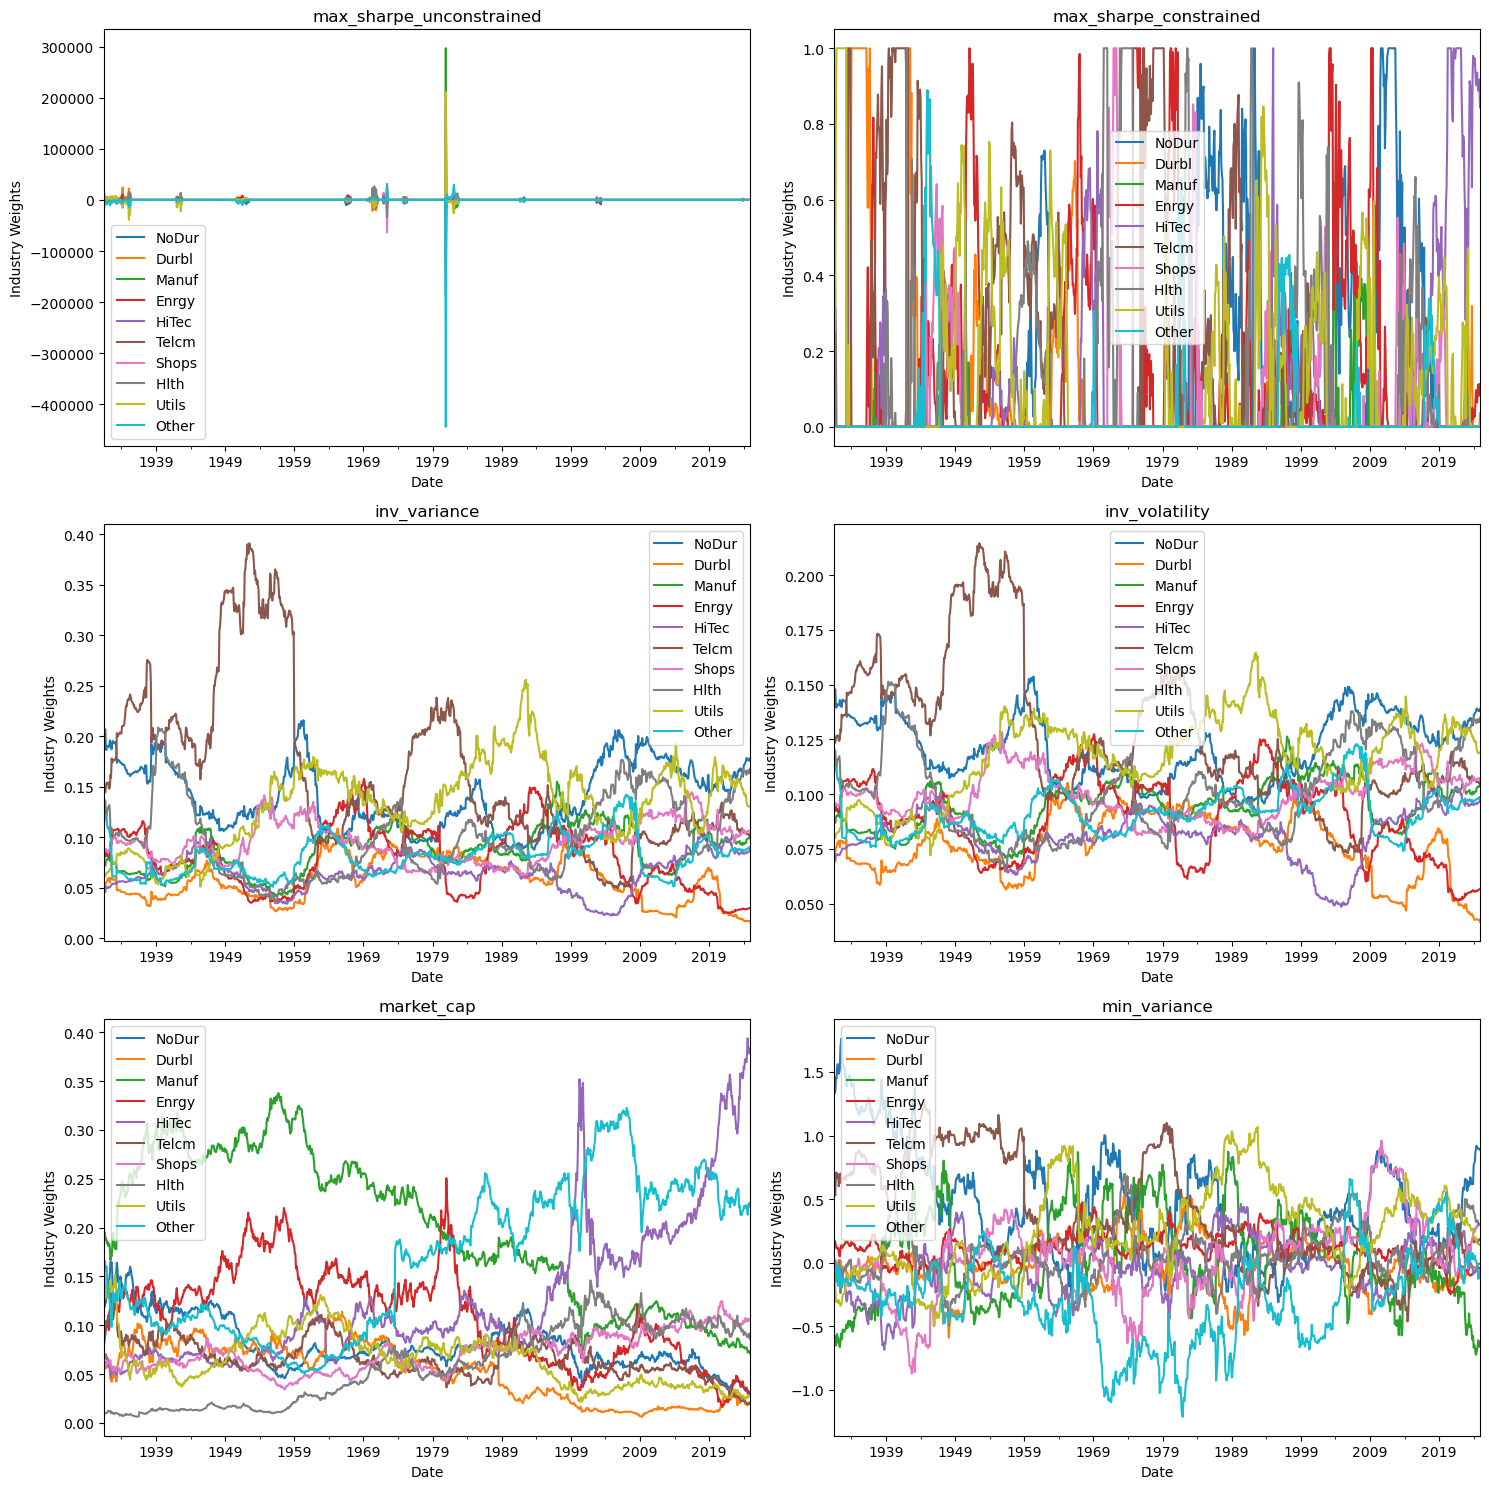

In [16]:
p_names = ['max_sharpe_unconstrained', 'max_sharpe_constrained',
                  'inv_variance', 'inv_volatility', 'equal_weight',
                  'market_cap', 'min_variance']

# for each strategy p in p_names, plot industry weights (6 plots total - we exclude equal weighting)
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
plot_index = 0
for p in p_names:
    if p == 'equal_weight':
        continue
    ax = axs[plot_index // 2, plot_index % 2]
    portfolios[p].plot(ax=ax)
    ax.set_title(p)
    ax.set_ylabel('Industry Weights')
    ax.set_xlabel('Date')
    plot_index += 1
plt.tight_layout()
plt.show()

### Compute monthly returns for each strategy

In [17]:
# build dataframe of monthly returns for each strategy

monthly_returns = pd.DataFrame(index=portfolios[p_names[0]].index)

for strat in p_names:
    # Align returns with the weights index (which should correspond to the period t+1)
    strat_weights = portfolios[strat]
    strat_returns = returns_df.loc[strat_weights.index]
    # Compute the weighted returns for each period
    monthly_returns[strat] = (strat_weights * strat_returns).sum(axis=1)

monthly_returns.tail()

,max_sharpe_unconstrained,max_sharpe_constrained,inv_variance,inv_volatility,equal_weight,market_cap,min_variance
2024-08-01,6.799129,0.924621,3.046167,2.472924,1.575,2.093735,6.076010
2024-09-01,-28.943726,2.274460,2.288447,2.593588,3.135,2.177889,1.001709
2024-10-01,-2.925308,-0.237175,-1.099623,-1.010721,-1.015,-0.589349,-0.843588
2024-11-01,-10.588572,5.109976,5.658203,6.692650,8.412,6.855432,0.217701
2024-12-01,18.170904,0.535085,-5.172209,-4.792141,-3.944,-2.830418,-3.754198


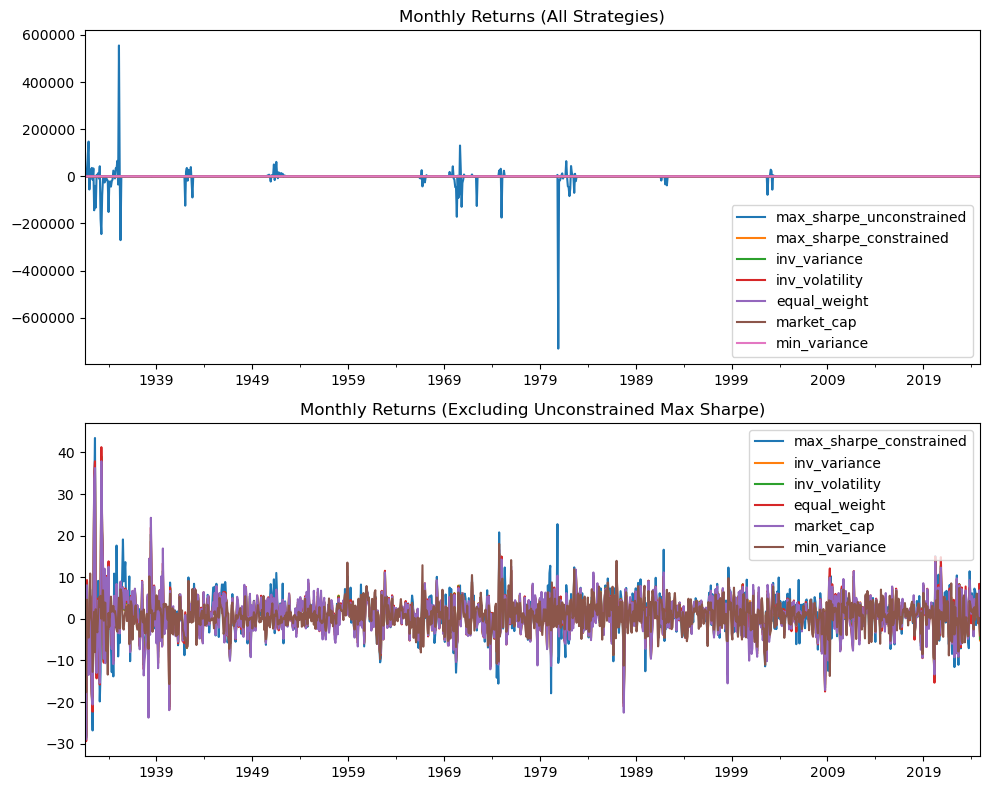

In [18]:
# plot monthly returns series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

monthly_returns.plot(ax=axes[0])
axes[0].set_title('Monthly Returns (All Strategies)')

monthly_returns.drop('max_sharpe_unconstrained', axis=1).plot(ax=axes[1])
axes[1].set_title('Monthly Returns (Excluding Unconstrained Max Sharpe)')

plt.tight_layout()
plt.show()


### Compare performance

In [19]:
# periods of interest
periods = {
    'Jul1931-Dec2025': ('1931-07-01', '2025-12-31'),
    'Jan1990-Dec2025': ('1990-01-01', '2025-12-31'),
    'Jan2000-Dec2025': ('2000-01-01', '2025-12-31')
}

performance_results = {}

for period_label, (start_date, end_date) in periods.items():
    period_returns = monthly_returns.loc[start_date:end_date]

    avg_monthly = period_returns.mean()

    total_return = ((1 + period_returns / 100).prod() - 1) * 100
    
    excess_returns = period_returns.subtract(rf.loc[start_date:end_date], axis=0)
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(12)
    
    performance_results[period_label] = pd.DataFrame({
        'Average Monthly Return': avg_monthly,
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio
    })

combined_performance = pd.concat(performance_results, axis=1)

print(combined_performance)


                                Jul1931-Dec2025                             \
                         Average Monthly Return  Total Return Sharpe Ratio   
max_sharpe_unconstrained           -1840.885139           inf    -0.183096   
max_sharpe_constrained                 1.015904  1.886686e+06     0.495927   
inv_variance                           0.978018  1.678318e+06     0.527284   
inv_volatility                         0.998281  1.889944e+06     0.519157   
equal_weight                           1.017845  2.079719e+06     0.509270   
market_cap                             0.980424  1.271993e+06     0.472654   
min_variance                           0.760797  2.391366e+05     0.473898   

                                Jan1990-Dec2025                             \
                         Average Monthly Return  Total Return Sharpe Ratio   
max_sharpe_unconstrained            -395.541090  1.542949e+24    -0.240851   
max_sharpe_constrained                 0.904673  2.853952e+03  

/Users/schoff/Documents/School/HEC/2025 Winter/FINA 60202A/venv/lib/python3.11/site-packages/numpy/core/_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
